### Import Libraries

In [23]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

import time
import warnings
warnings.filterwarnings("ignore")
import gc
import os
import cv2

from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain

from itertools import chain
from skimage.color import rgb2gray
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model

from mpl_toolkits.axes_grid1 import ImageGrid

### Reproducibility

In [4]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

### Training  images

In [5]:
train_files = []
mask_files = glob('../data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [10]:
x = mask_files[20]
np.max(cv2.imread(x))

0

### Data Distribution by creating table

In [15]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
    
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})    

In [16]:
df.head()

,image_path,mask_path,diagnosis
0,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,0
1,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1
2,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1
3,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1
4,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,../data/lgg-mri-segmentation/kaggle_3m\TCGA_CS...,1


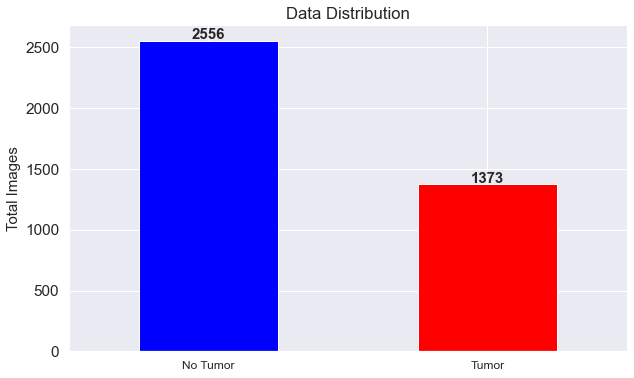

In [17]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Visulaize MRI Images with masks

In [24]:
df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

In [25]:
def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(25,25))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Images', fontsize=15)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Masks', fontsize=15)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.4)
        grid[2].set_title('Brain MRI with mask', fontsize=15)
        grid[2].axis('off')

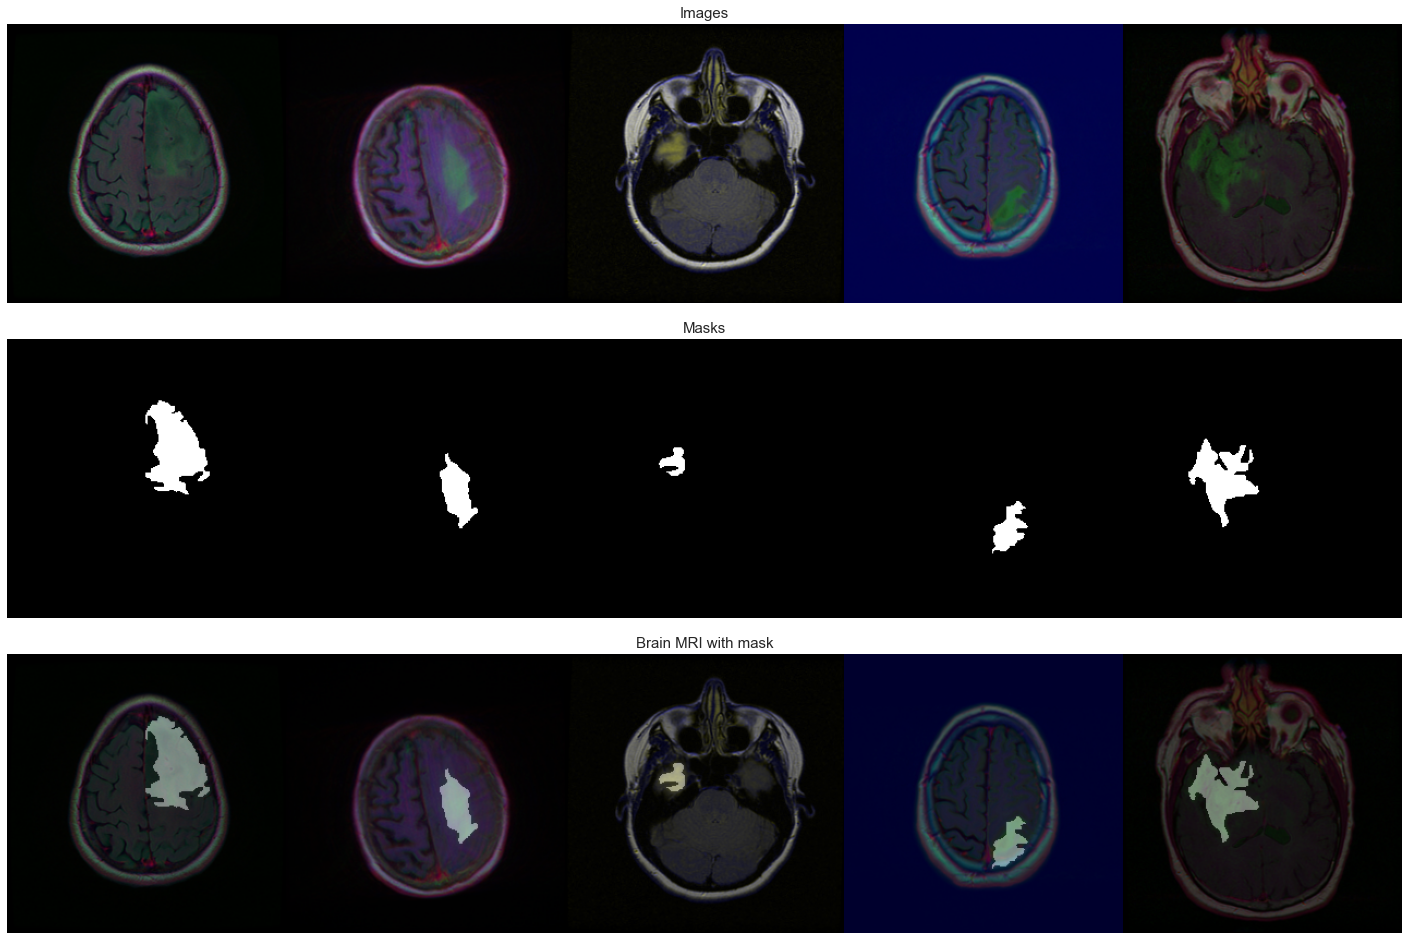

In [26]:
show_data(df_positive)

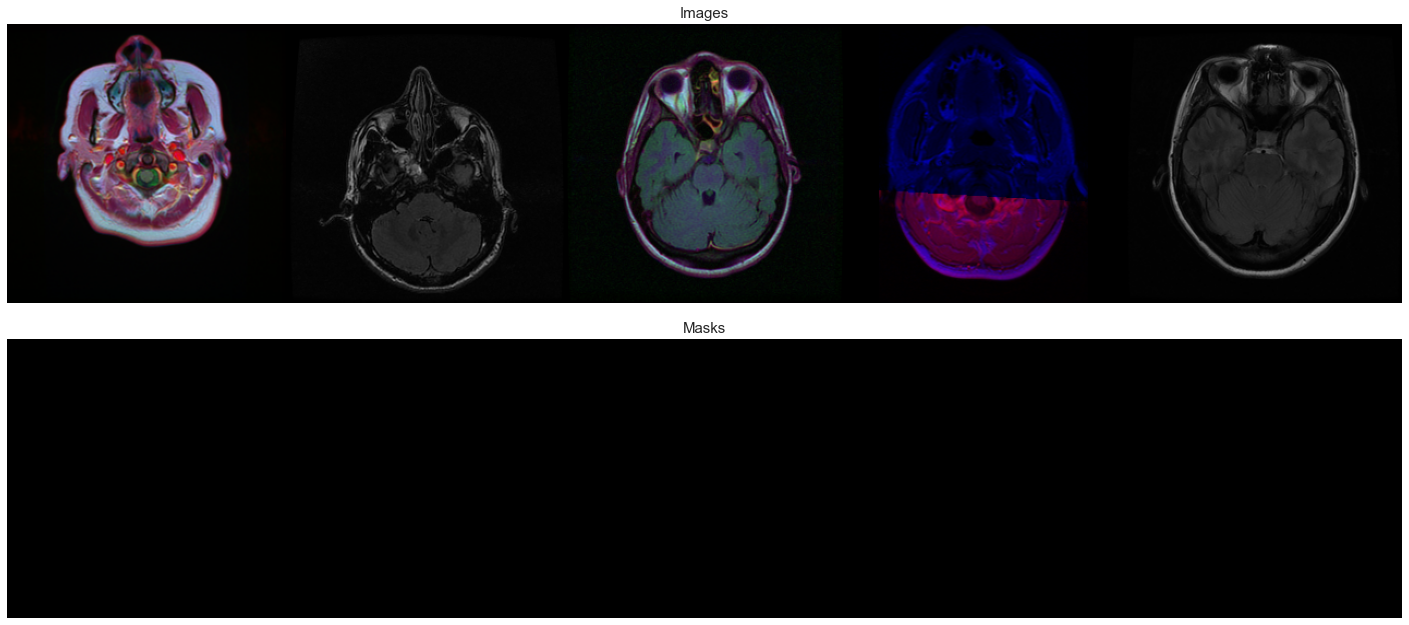

In [27]:
show_data(df_negative, positive=False)

### Split data into Train, Validation and Test Set

In [28]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)
